# Properties, Case Studies and Categorization 

In [ ]:
import jetutils
from jetutils.jet_finding import *
from jetutils.definitions import *
from jetutils.anyspell import mask_from_spells_pl
from jetutils.plots import *
from jetutils.clustering import *
from jetutils.data import *
from jetutils.jet_finding import JetFindingExperiment, get_double_jet_index, find_all_jets
from jetutils.definitions import DATADIR, get_index_columns, SEASONS, PRETTIER_VARNAME, UNITS, JJADOYS, FIGURES, KAPPA
from jetutils.plots import plot_seasonal, plot_trends, trends_and_pvalues, num2tex, COLORS, periodic_rolling_pl
from jetutils.data import DataHandler, flatten_by, standardize, metadata_from_da, find_spot 
from pathlib import Path
import colormaps

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import glob
import os
import seaborn as sns
import autoreload
import matplotlib.gridspec as gridspec
import calendar
from datetime import datetime, timedelta

%matplotlib inline
print(jetutils.__file__)

Found config override file at  /home/mabeling/.jetutils.ini
Guessed N_WORKERS :  256
Guessed MEMORY_LIMIT :  8000
/home/mabeling/Jetutils-NP/jetutils/__init__.py


In [ ]:
# Open the flattened files
basepath = "/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined"
#basepath_mid = "/scratch2/mabeling/data/ERA5/plev/mid_wind/6H/data/combined"

ds = xr.open_dataset(basepath + "/uvtths_plevhigh_1959_2022.nc")

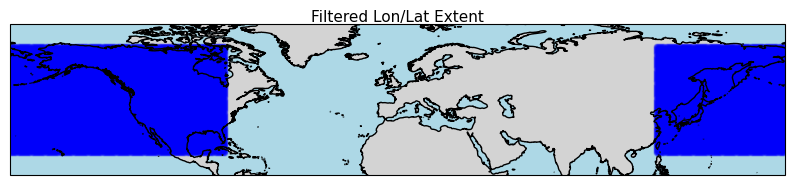

In [ ]:
# Create 2D meshgrid of lon and lat for plotting points
lon2d, lat2d = np.meshgrid(ds.lon.values, ds.lat.values)

lon_flat = lon2d.flatten()
lat_flat = lat2d.flatten()

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.scatter(lon_flat, lat_flat, s=10, alpha=0.2, color='blue', transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

ax.set_extent([120, 280, 10, 80], crs=ccrs.PlateCarree())

plt.title('Filtered Lon/Lat Extent')
plt.show()

In [ ]:
exp = JetFindingExperiment(DataHandler.from_basepath_and_da(basepath, ds, save_da=True))
#dh_low = DataHandler.from_basepath_and_da(basepath_mid, dm, save_da=True)
ds = exp.ds

In [17]:
exp.path

PosixPath('/scratch2/mabeling/data/ERA5/plev/high_wind/6H/data/combined/9')

In [18]:
ds

<xarray.Dataset> Size: 73GB
Dimensions:  (time: 93500, lat: 101, lon: 321)
Coordinates:
  * time     (time) datetime64[ns] 748kB 1959-01-01 ... 2022-12-31T18:00:00
  * lon      (lon) float32 1kB 120.0 120.5 121.0 121.5 ... -81.0 -80.5 -80.0
  * lat      (lat) float32 404B 20.0 20.5 21.0 21.5 22.0 ... 68.5 69.0 69.5 70.0
Data variables:
    t        (time, lat, lon) float32 12GB ...
    u        (time, lat, lon) float32 12GB ...
    v        (time, lat, lon) float32 12GB ...
    theta    (time, lat, lon) float32 12GB ...
    s        (time, lat, lon) float32 12GB ...
    lev      (time, lat, lon) float32 12GB ...
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    institution:    ECMWF
    orig_lev:       [150. 200. 250. 300. 350.]
    flattened:      1

In [ ]:
all_jets_one_df = exp.find_jets()

In [20]:
all_jets_one_df

shape: (9_514_838, 19)
┌─────────────────────┬────────┬───────┬────────┬───┬───────────┬──────┬─────┬──────────┐
│ time                ┆ jet ID ┆ index ┆ lon    ┆ … ┆ alignment ┆ diff ┆ len ┆ is_polar │
│ ---                 ┆ ---    ┆ ---   ┆ ---    ┆   ┆ ---       ┆ ---  ┆ --- ┆ ---      │
│ datetime[ns]        ┆ u32    ┆ i64   ┆ f32    ┆   ┆ f32       ┆ f32  ┆ u32 ┆ f64      │
╞═════════════════════╪════════╪═══════╪════════╪═══╪═══════════╪══════╪═════╪══════════╡
│ 1959-01-01 00:00:00 ┆ 0      ┆ 0     ┆ 120.5  ┆ … ┆ null      ┆ 5.0  ┆ 102 ┆ 0.657359 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 1     ┆ 122.0  ┆ … ┆ 0.999447  ┆ 1.5  ┆ 102 ┆ 0.661563 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 2     ┆ 123.5  ┆ … ┆ 0.999139  ┆ 1.5  ┆ 102 ┆ 0.663802 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 3     ┆ 125.0  ┆ … ┆ 0.999996  ┆ 1.5  ┆ 102 ┆ 0.666957 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 4     ┆ 126.5  ┆ … ┆ 0.999362  ┆ 1.5  ┆ 102 ┆ 0.666527 │
│ …                   ┆ …      ┆ …     ┆ …      ┆ … ┆ …         ┆ …    ┆ …   ┆ …        │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 106   ┆ -104.5 ┆ … ┆ 0.948947  ┆ 1.5  ┆ 112 ┆ 0.345193 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 107   ┆ -103.0 ┆ … ┆ 0.933013  ┆ 1.5  ┆ 112 ┆ 0.340746 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 108   ┆ -101.5 ┆ … ┆ 0.999292  ┆ 1.5  ┆ 112 ┆ 0.374517 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 109   ┆ -100.0 ┆ … ┆ 0.999295  ┆ 1.5  ┆ 112 ┆ 0.670643 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 110   ┆ -98.5  ┆ … ┆ 0.999649  ┆ 1.5  ┆ 112 ┆ 0.658889 │
└─────────────────────┴────────┴───────┴────────┴───┴───────────┴──────┴─────┴──────────┘

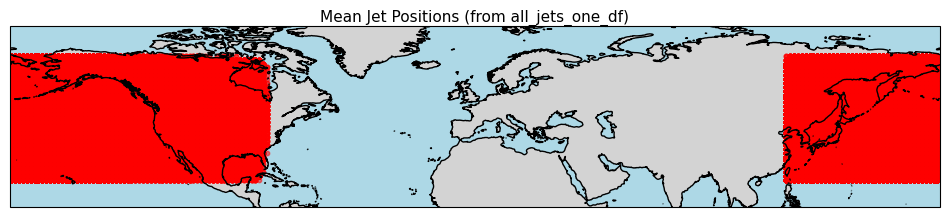

In [ ]:
lons = all_jets_one_df["lon"].to_numpy()
lats = all_jets_one_df["lat"].to_numpy()

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.scatter(lons, lats, s=10, alpha=0.5, color="red", transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Region: North Pacific (adjusted to cross dateline)
ax.set_extent([120, 280, 10, 80], crs=ccrs.PlateCarree())

plt.title("Mean Jet Positions")
plt.show()

In [ ]:
time = "month"
thresh = "06"
init = "def"
all_jets_one_df_cats = exp.categorize_jets(feature_names=("s", "theta"), mode=time)#, force=1)

In [23]:
all_jets_one_df_cats

shape: (9_514_838, 19)
┌─────────────────────┬────────┬───────┬────────┬───┬───────────┬──────┬─────┬──────────┐
│ time                ┆ jet ID ┆ index ┆ lon    ┆ … ┆ alignment ┆ diff ┆ len ┆ is_polar │
│ ---                 ┆ ---    ┆ ---   ┆ ---    ┆   ┆ ---       ┆ ---  ┆ --- ┆ ---      │
│ datetime[ns]        ┆ u32    ┆ i64   ┆ f32    ┆   ┆ f32       ┆ f32  ┆ u32 ┆ f64      │
╞═════════════════════╪════════╪═══════╪════════╪═══╪═══════════╪══════╪═════╪══════════╡
│ 1959-01-01 00:00:00 ┆ 0      ┆ 0     ┆ 120.5  ┆ … ┆ null      ┆ 5.0  ┆ 102 ┆ 0.657359 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 1     ┆ 122.0  ┆ … ┆ 0.999447  ┆ 1.5  ┆ 102 ┆ 0.661563 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 2     ┆ 123.5  ┆ … ┆ 0.999139  ┆ 1.5  ┆ 102 ┆ 0.663802 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 3     ┆ 125.0  ┆ … ┆ 0.999996  ┆ 1.5  ┆ 102 ┆ 0.666957 │
│ 1959-01-01 00:00:00 ┆ 0      ┆ 4     ┆ 126.5  ┆ … ┆ 0.999362  ┆ 1.5  ┆ 102 ┆ 0.666527 │
│ …                   ┆ …      ┆ …     ┆ …      ┆ … ┆ …         ┆ …    ┆ …   ┆ …        │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 106   ┆ -104.5 ┆ … ┆ 0.948947  ┆ 1.5  ┆ 112 ┆ 0.345193 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 107   ┆ -103.0 ┆ … ┆ 0.933013  ┆ 1.5  ┆ 112 ┆ 0.340746 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 108   ┆ -101.5 ┆ … ┆ 0.999292  ┆ 1.5  ┆ 112 ┆ 0.374517 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 109   ┆ -100.0 ┆ … ┆ 0.999295  ┆ 1.5  ┆ 112 ┆ 0.670643 │
│ 2022-12-31 18:00:00 ┆ 0      ┆ 110   ┆ -98.5  ┆ … ┆ 0.999649  ┆ 1.5  ┆ 112 ┆ 0.658889 │
└─────────────────────┴────────┴───────┴────────┴───┴───────────┴──────┴─────┴──────────┘

In [24]:
props_as_df_uncat = exp.props_as_df(False) 

In [25]:
props_as_df_uncat

shape: (82_090, 22)
┌────────────┬────────┬────────────┬───────────┬───┬────────────┬───────────┬──────────┬───────────┐
│ time       ┆ jet ID ┆ mean_lon   ┆ mean_lat  ┆ … ┆ int        ┆ int_over_ ┆ is_polar ┆ width     │
│ ---        ┆ ---    ┆ ---        ┆ ---       ┆   ┆ ---        ┆ namerica  ┆ ---      ┆ ---       │
│ datetime[n ┆ u32    ┆ f32        ┆ f32       ┆   ┆ f32        ┆ ---       ┆ f64      ┆ f32       │
│ s]         ┆        ┆            ┆           ┆   ┆            ┆ f32       ┆          ┆           │
╞════════════╪════════╪════════════╪═══════════╪═══╪════════════╪═══════════╪══════════╪═══════════╡
│ 1959-01-01 ┆ 0      ┆ 175.32132  ┆ 30.73428  ┆ … ┆ 7.35950272 ┆ 0.0       ┆ 0.768788 ┆ 616686.5  │
│ 00:00:00   ┆        ┆            ┆           ┆   ┆ e8         ┆           ┆          ┆           │
│ 1959-01-01 ┆ 0      ┆ 170.148804 ┆ 29.579266 ┆ … ┆ 6.78016384 ┆ 0.0       ┆ 0.767549 ┆ 668988.75 │
│ 06:00:00   ┆        ┆            ┆           ┆   ┆ e8         ┆           ┆          ┆           │
│ 1959-01-01 ┆ 0      ┆ -153.12718 ┆ 39.616238 ┆ … ┆ 9.9934976e ┆ 2.3688414 ┆ 0.821918 ┆ 889739.18 │
│ 12:00:00   ┆        ┆ 2          ┆           ┆   ┆ 8          ┆ 4e8       ┆          ┆ 75        │
│ 1959-01-01 ┆ 0      ┆ 148.983414 ┆ 39.150887 ┆ … ┆ 7.12719488 ┆ 0.0       ┆ 0.797577 ┆ 1184529.5 │
│ 18:00:00   ┆        ┆            ┆           ┆   ┆ e8         ┆           ┆          ┆           │
│ 1959-01-02 ┆ 0      ┆ -142.93989 ┆ 46.139832 ┆ … ┆ 6.16578752 ┆ 1.6657006 ┆ 0.821388 ┆ 730330.62 │
│ 00:00:00   ┆        ┆ 6          ┆           ┆   ┆ e8         ┆ 4e8       ┆          ┆ 5         │
│ …          ┆ …      ┆ …          ┆ …         ┆ … ┆ …          ┆ …         ┆ …        ┆ …         │
│ 2022-12-30 ┆ 0      ┆ -172.87614 ┆ 35.262085 ┆ … ┆ 1.1609e9   ┆ 1.9418537 ┆ 0.227209 ┆ 904632.93 │
│ 18:00:00   ┆        ┆ 4          ┆           ┆   ┆            ┆ 6e8       ┆          ┆ 75        │
│ 2022-12-31 ┆ 0      ┆ -171.75791 ┆ 35.046707 ┆ … ┆ 1.1798e9   ┆ 2.0398179 ┆ 0.245626 ┆ 954139.93 │
│ 00:00:00   ┆        ┆ 9          ┆           ┆   ┆            ┆ 2e8       ┆          ┆ 75        │
│ 2022-12-31 ┆ 0      ┆ -171.92500 ┆ 34.702641 ┆ … ┆ 1.1467e9   ┆ 1.9758649 ┆ 0.275293 ┆ 961762.06 │
│ 06:00:00   ┆        ┆ 3          ┆           ┆   ┆            ┆ 6e8       ┆          ┆ 25        │
│ 2022-12-31 ┆ 0      ┆ -169.75656 ┆ 34.784054 ┆ … ┆ 1.1573e9   ┆ 2.0761468 ┆ 0.261468 ┆ 996506.25 │
│ 12:00:00   ┆        ┆ 1          ┆           ┆   ┆            ┆ 8e8       ┆          ┆           │
│ 2022-12-31 ┆ 0      ┆ -171.59187 ┆ 35.143169 ┆ … ┆ 1.1364e9   ┆ 1.8034470 ┆ 0.293471 ┆ 948330.43 │
│ 18:00:00   ┆        ┆ 3          ┆           ┆   ┆            ┆ 4e8       ┆          ┆ 75        │
└────────────┴────────┴────────────┴───────────┴───┴────────────┴───────────┴──────────┴───────────┘

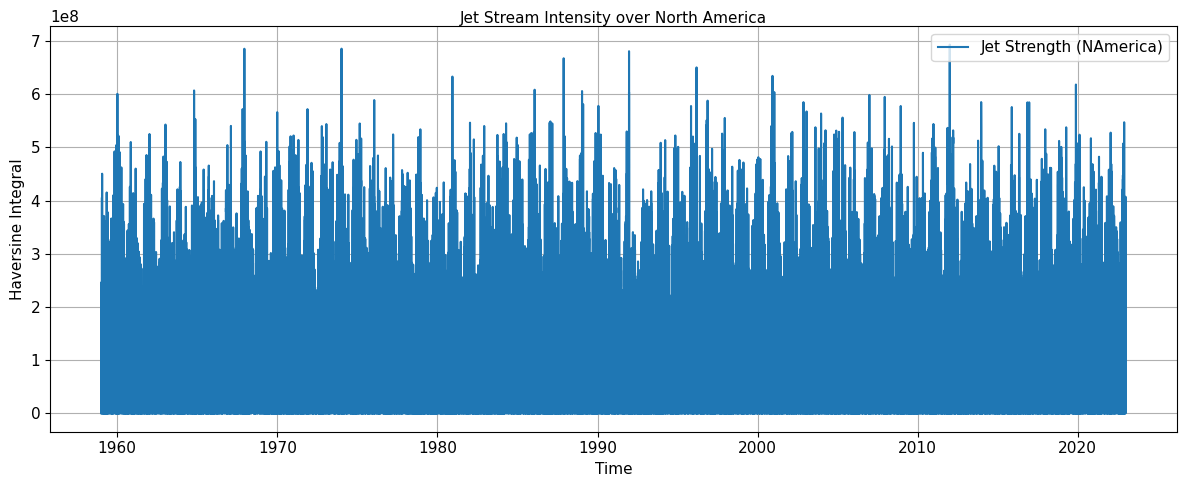

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(props_as_df_uncat["time"], props_as_df_uncat["int_over_namerica"], label="Jet Strength (NAmerica)")

plt.xlabel("Time")
plt.ylabel("Haversine Integral")
plt.title("Jet Stream Intensity over North America")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

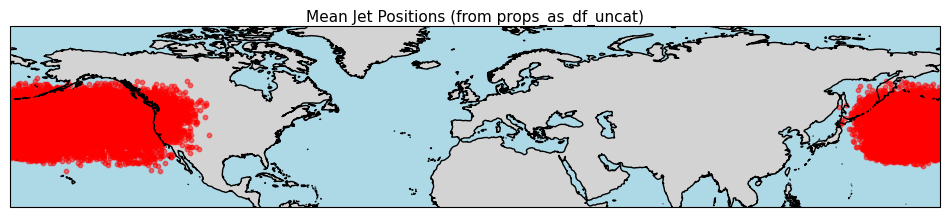

In [28]:
lons = props_as_df_uncat["mean_lon"].to_numpy()
lats = props_as_df_uncat["mean_lat"].to_numpy()

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.scatter(lons, lats, s=10, alpha=0.5, color="red", transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

ax.set_extent([120, 280, 10, 80], crs=ccrs.PlateCarree())

plt.title("Mean Jet Positions (from props_as_df_uncat)")
plt.show()

In [ ]:
#da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = exp.props_as_df(True)
props_as_df = pl.read_parquet(exp.path.joinpath("props_as_df.parquet"))
#props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
#props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [ ]:
props_as_df

shape: (159_778, 24)
┌──────────────┬─────┬─────────────┬───────────┬───┬──────────┬─────────────┬───────┬──────────────┐
│ time         ┆ jet ┆ mean_lon    ┆ mean_lat  ┆ … ┆ is_polar ┆ width       ┆ njets ┆ double_jet_i │
│ ---          ┆ --- ┆ ---         ┆ ---       ┆   ┆ ---      ┆ ---         ┆ ---   ┆ ndex         │
│ datetime[ns] ┆ str ┆ f32         ┆ f32       ┆   ┆ f64      ┆ f32         ┆ u8    ┆ ---          │
│              ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆ f64          │
╞══════════════╪═════╪═════════════╪═══════════╪═══╪══════════╪═════════════╪═══════╪══════════════╡
│ 1959-01-01   ┆ STJ ┆ null        ┆ null      ┆ … ┆ null     ┆ null        ┆ 0     ┆ 0.0          │
│ 00:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 1959-01-01   ┆ EDJ ┆ 175.32132   ┆ 30.734278 ┆ … ┆ 0.768788 ┆ 616686.5    ┆ 1     ┆ 0.0          │
│ 00:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 1959-01-01   ┆ STJ ┆ null        ┆ null      ┆ … ┆ null     ┆ null        ┆ 0     ┆ 0.0          │
│ 06:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 1959-01-01   ┆ EDJ ┆ 170.148804  ┆ 29.579266 ┆ … ┆ 0.767549 ┆ 668988.75   ┆ 1     ┆ 0.0          │
│ 06:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 1959-01-01   ┆ STJ ┆ null        ┆ null      ┆ … ┆ null     ┆ null        ┆ 0     ┆ 0.0          │
│ 12:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ …            ┆ …   ┆ …           ┆ …         ┆ … ┆ …        ┆ …           ┆ …     ┆ …            │
│ 2022-12-31   ┆ EDJ ┆ null        ┆ null      ┆ … ┆ null     ┆ null        ┆ 0     ┆ 0.0          │
│ 06:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 2022-12-31   ┆ STJ ┆ -169.756561 ┆ 34.784054 ┆ … ┆ 0.261468 ┆ 996506.25   ┆ 1     ┆ 0.0          │
│ 12:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 2022-12-31   ┆ EDJ ┆ null        ┆ null      ┆ … ┆ null     ┆ null        ┆ 0     ┆ 0.0          │
│ 12:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 2022-12-31   ┆ STJ ┆ -171.591873 ┆ 35.143169 ┆ … ┆ 0.293471 ┆ 948330.4375 ┆ 1     ┆ 0.0          │
│ 18:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
│ 2022-12-31   ┆ EDJ ┆ null        ┆ null      ┆ … ┆ null     ┆ null        ┆ 0     ┆ 0.0          │
│ 18:00:00     ┆     ┆             ┆           ┆   ┆          ┆             ┆       ┆              │
└──────────────┴─────┴─────────────┴───────────┴───┴──────────┴─────────────┴───────┴──────────────┘

In [35]:
# 2 cats for winter + one cat for all summer jets
def categorize_jets_three(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        pl.when(pl.col("time").dt.month().is_in([12, 1, 2, 3]))
        .then(pl.col("jet"))                # keep original jet in winter
        .otherwise(pl.lit("ALL"))           # collapse into ALL otherwise
        .alias("jet")
    )

In [ ]:
props_as_df_test = categorize_jets_three(props_as_df)

data_vars_small = [
    "mean_lat",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
    "int_over_namerica",
]

data_vars_medium = [
    "mean_lat",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
    "int_over_namerica",
]

data_vars_medium_DJF = [
    "mean_lat",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
    "int_over_namerica",
    "mean_theta",
    "njets",
]

data_vars_all = [
    "mean_lat",
    "mean_lon",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_namerica",
    "double_jet_index",
    "is_polar",
    "mean_theta",
]

In [ ]:
data_vars = [
    "mean_lat",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
    "njets"
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        props_as_df,
        data_vars,
        season,
        n_boostraps=1000,
        nrows=2,
        ncols=3,
        clear=False,
        suffix="_subset",
        numbering=True,
        save=True
    )

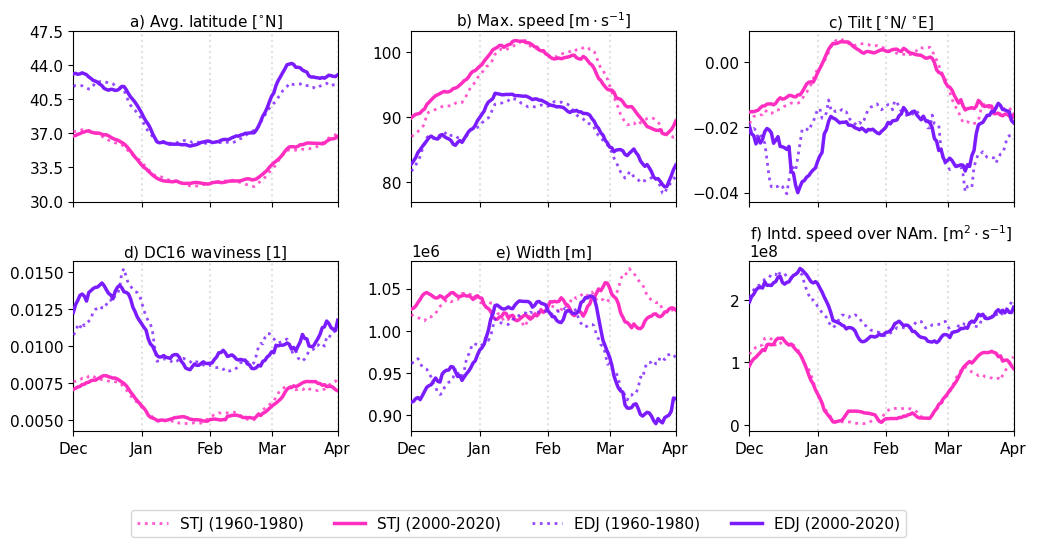

In [ ]:
_ = plot_seasonal_winter_jets_difference( # implement new for 1980 !
    props_as_df, data_vars_small, nrows=2, ncols=3, clear=False, suffix=f"_init{init}_{time}_int{thresh}_complete_4Months", numbering=True, save=True, period1=(1960,1980), period2=(2000,2020),
)  #daily means by winter day, jet type and two periods + 15-day rolling average

# Case studies

## Precipitation events

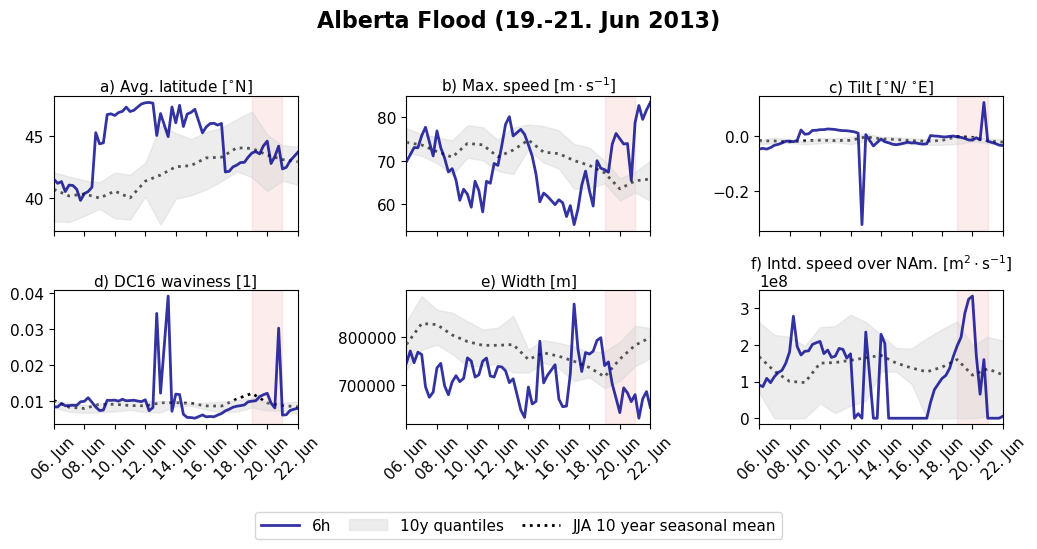

In [43]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, start_date = "06062013", end_date = "22062013", season = "JJA", nrows=2, ncols=3, suffix=f"AlbertaFlood2013_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "19062013" , end_date_EE =  "21062013", case_name= "Alberta Flood", use_6h_data=True)

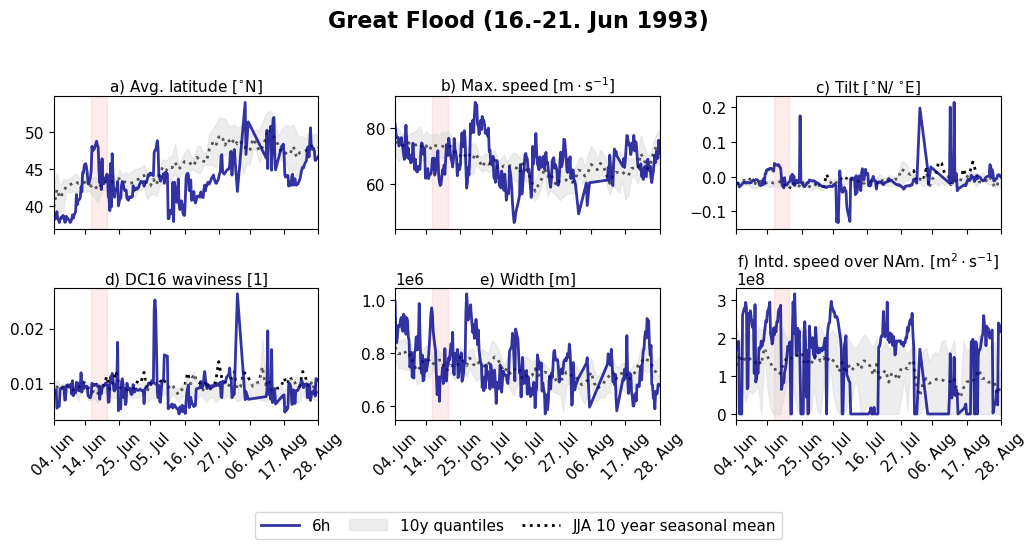

In [44]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, start_date = "04061993", end_date = "28081993", season = "JJA", nrows=2, ncols=3, suffix=f"Flood1993_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "16061993" , end_date_EE =  "21061993", case_name= "Great Flood", use_6h_data=True)

### 2021 BC flood mid November 

/home/mabeling/Jetutils-NP/jetutils/plots.py:1799: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  circ_df = pl.DataFrame(circ_stats, schema=["doy", "mean", "low", "high"]).sort("doy")


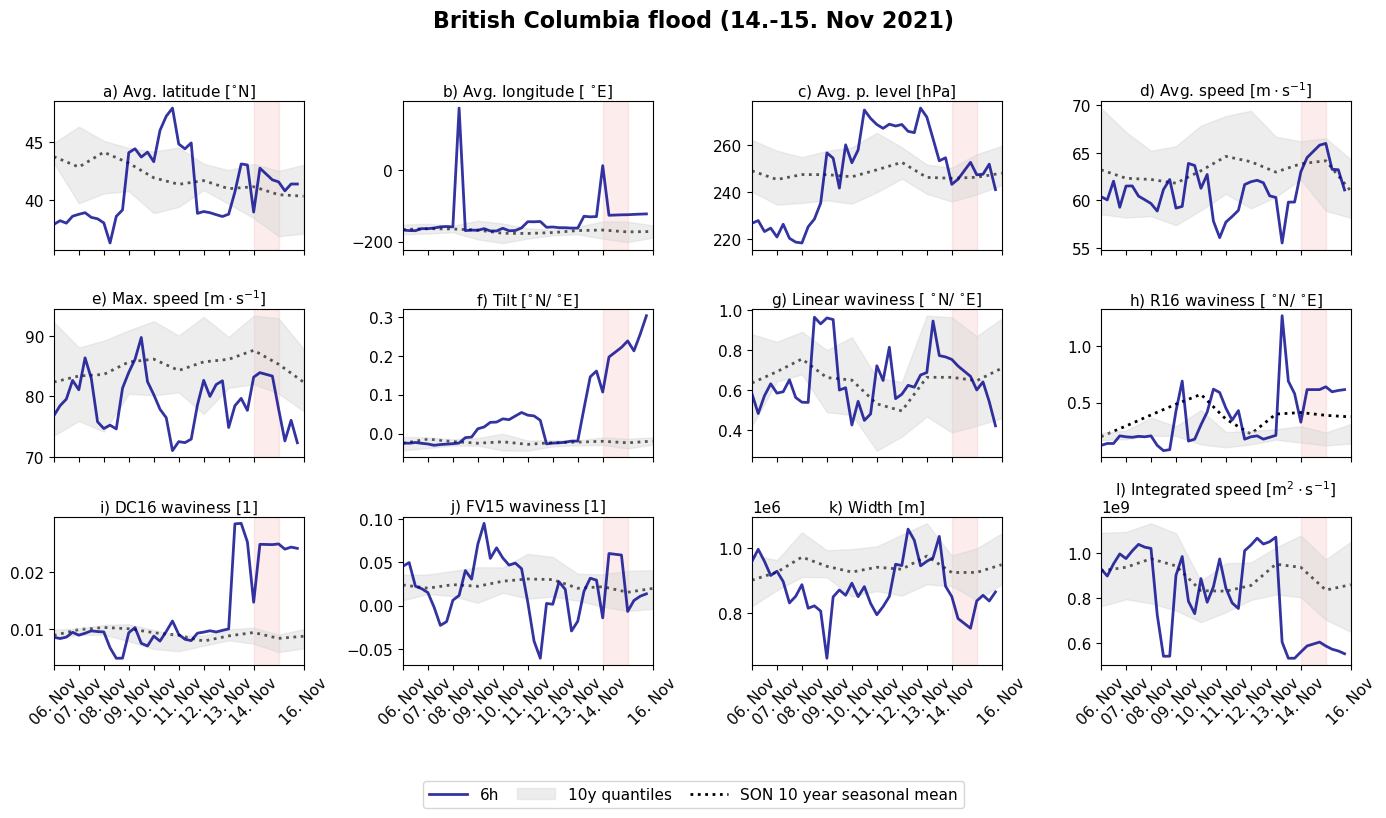

In [45]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_all, start_date = "06112021", end_date = "16112021", season = "SON", suffix=f"BCFlood2021_all",  numbering=True, save=True, n_xticks = 10, start_date_EE =  "14112021" , end_date_EE =  "15112021", case_name= "British Columbia flood", use_6h_data=True)

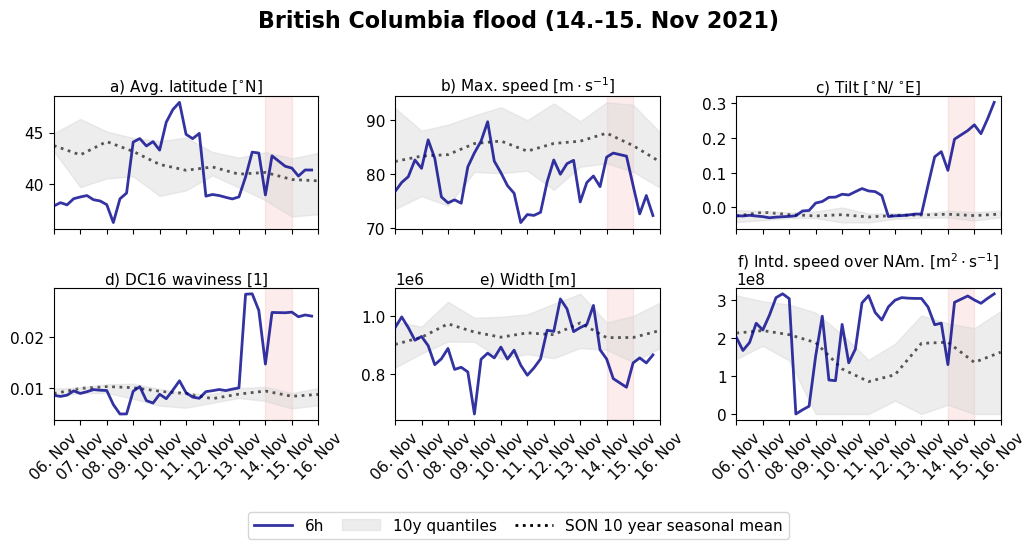

In [46]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium,  nrows=2, ncols=3, start_date = "06112021", end_date = "16112021", season = "SON", suffix=f"BCFlood2021_med",  numbering=True, save=True, n_xticks = 11, start_date_EE =  "14112021" , end_date_EE =  "15112021", case_name= "British Columbia flood", use_6h_data=True)

## Heatwaves

### Chicago Heatwave 1995

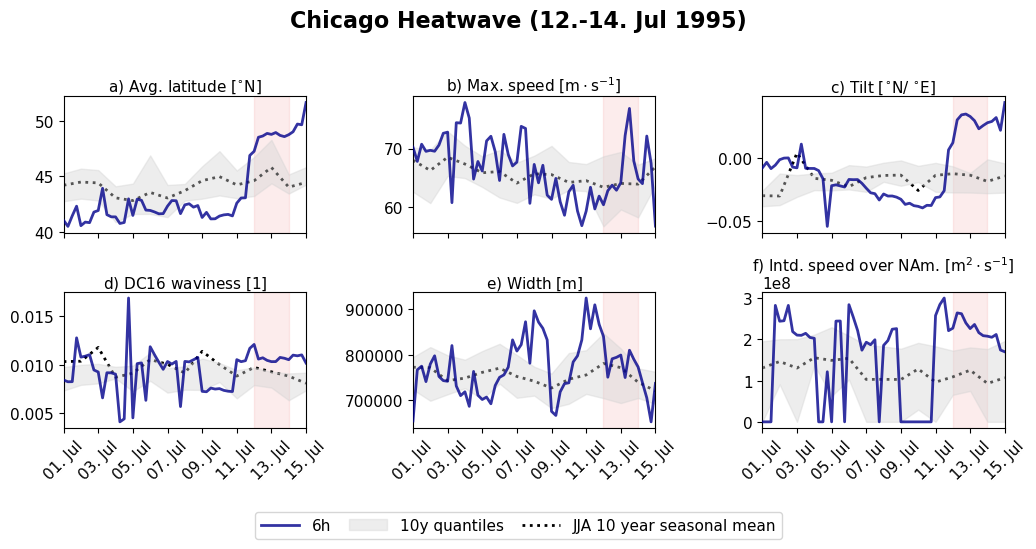

In [47]:
_ = plot_case_study_NEW(props_as_df_test, data_vars_medium,  nrows=2, ncols=3,start_date = "01071995", end_date = "15071995", season = "JJA", suffix=f"ChicagoHeatwave1995_medium",  numbering=True, save=True, n_xticks = 8, start_date_EE =  "12071995" , end_date_EE =  "14071995", case_name= "Chicago Heatwave")

### 2021 Heatwave Northwest US and West Canada

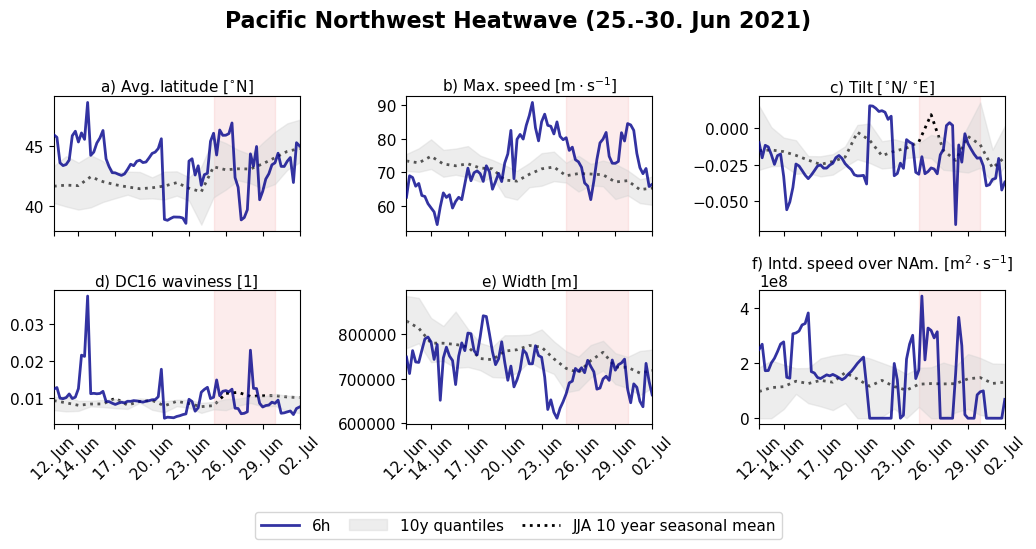

In [53]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, nrows=2, ncols=3,start_date = "12062021", end_date = "02072021", season = "JJA", suffix=f"Heatwave2021PacificNorthwest_medium",  numbering=True, save=True, n_xticks = 8, start_date_EE =  "25062021" , end_date_EE =  "30062021", case_name= "Pacific Northwest Heatwave", use_6h_data=True)# ALL

### 2007 HW October Cali + NAmerican HW

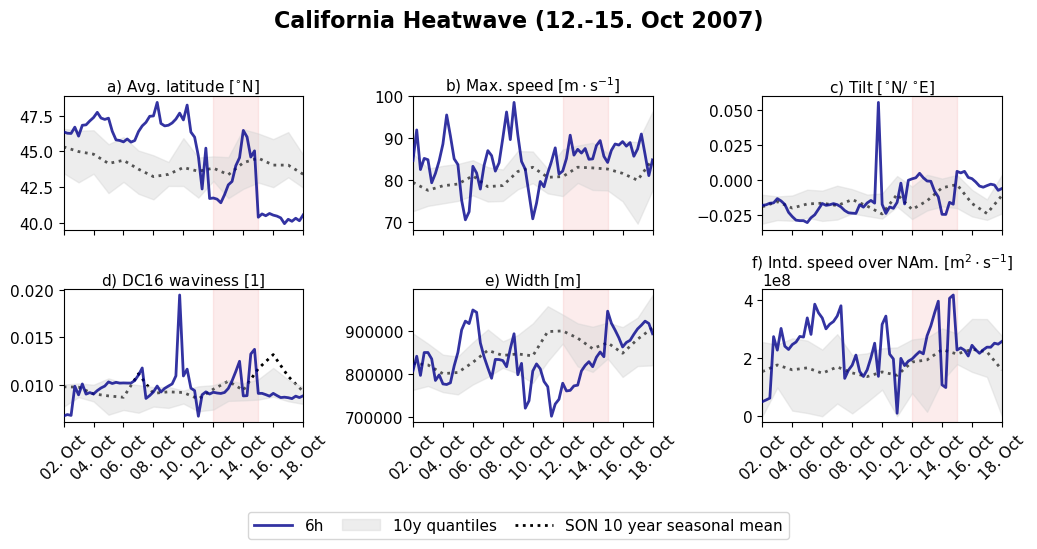

In [55]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, nrows=2, ncols=3,start_date = "02102007", end_date = "18102007", season = "SON", suffix=f"CaliforniaHeatwave2007_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "12102007" , end_date_EE =  "15102007", case_name= "California Heatwave", use_6h_data=True)

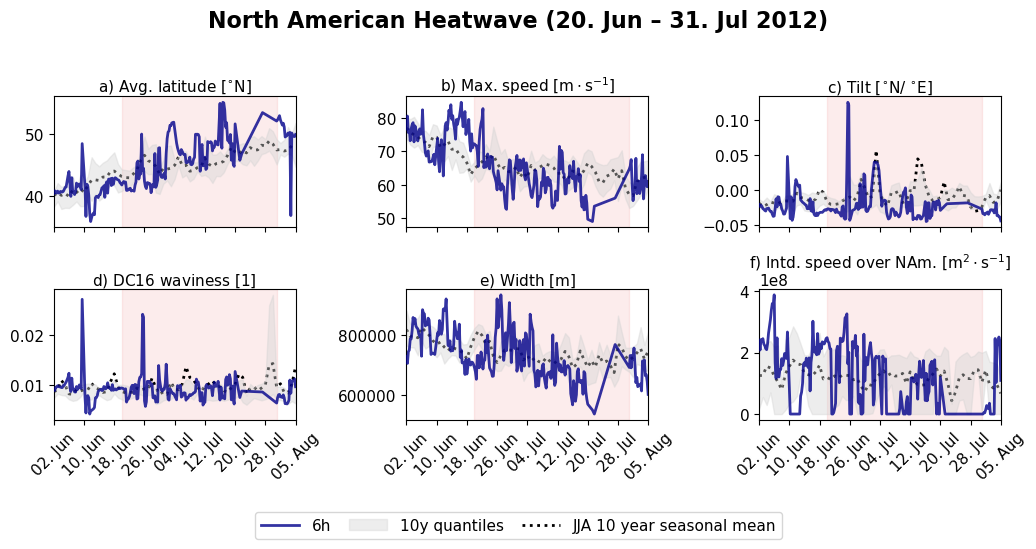

In [56]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, nrows=2, ncols=3,start_date = "02062012", end_date = "05082012", season = "JJA", suffix=f"NAHeatwave2012_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "20062012" , end_date_EE =  "31072012", case_name= "North American Heatwave", use_6h_data=True)

## McMurray, Canada 2016 Wildfire 01.05 - 05.07.2016

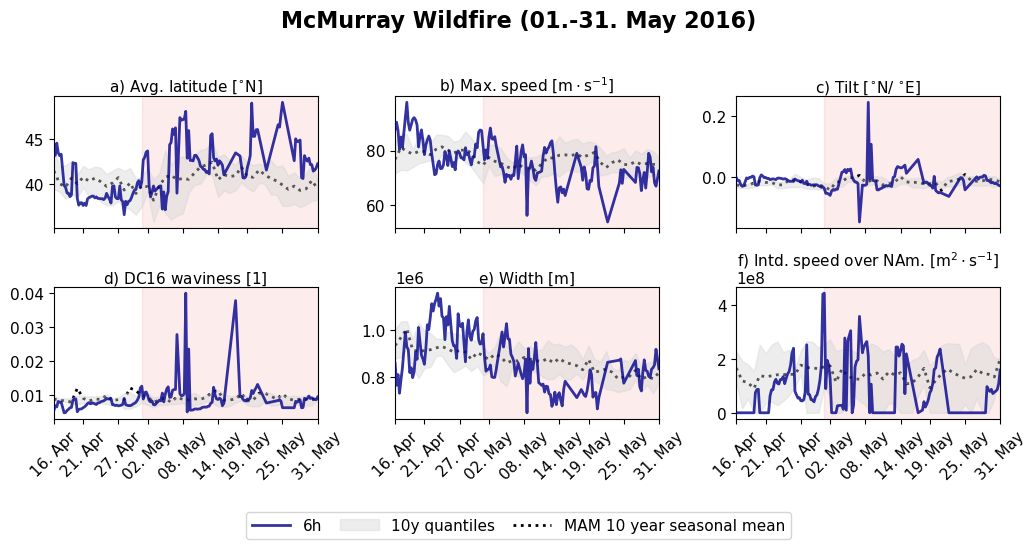

In [58]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, nrows=2, ncols=3,start_date = "16042016", end_date = "31052016", season = "MAM", suffix=f"McMurrayWildfire2016_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "01052016" , end_date_EE =  "31052016", case_name= "McMurray Wildfire", use_6h_data=True)

## Wildfire North America 2017

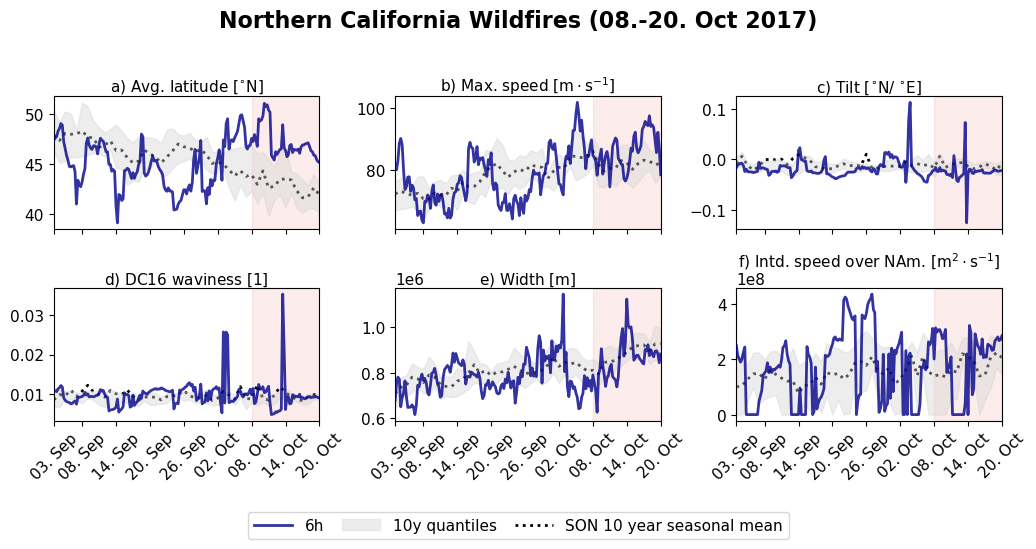

In [59]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium, nrows=2, ncols=3,start_date = "03092017", end_date = "20102017", season = "SON", suffix=f"CaliWildfire2017_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "08102017" , end_date_EE =  "20102017", case_name= "Northern California Wildfires", use_6h_data=True)

## Cold spells

### Eastern Rockies Oct. 2007 

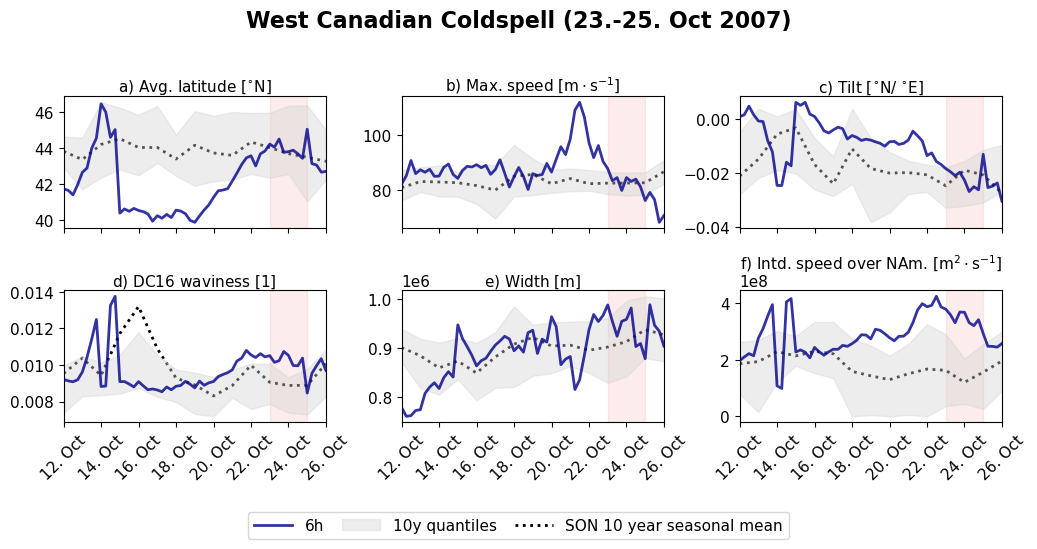

In [62]:
_ = plot_case_study_NEW(props_as_df_test, data_vars_medium,nrows=2, ncols=3,  start_date = "12102007", end_date = "26102007", season = "SON", suffix=f"CanadianColdspell2007_med",  numbering=True, save=True, n_xticks = 8, start_date_EE =  "23102007" , end_date_EE =  "25102007", case_name= "West Canadian Coldspell", use_6h_data=True)

### Cold Spell Feb 2019

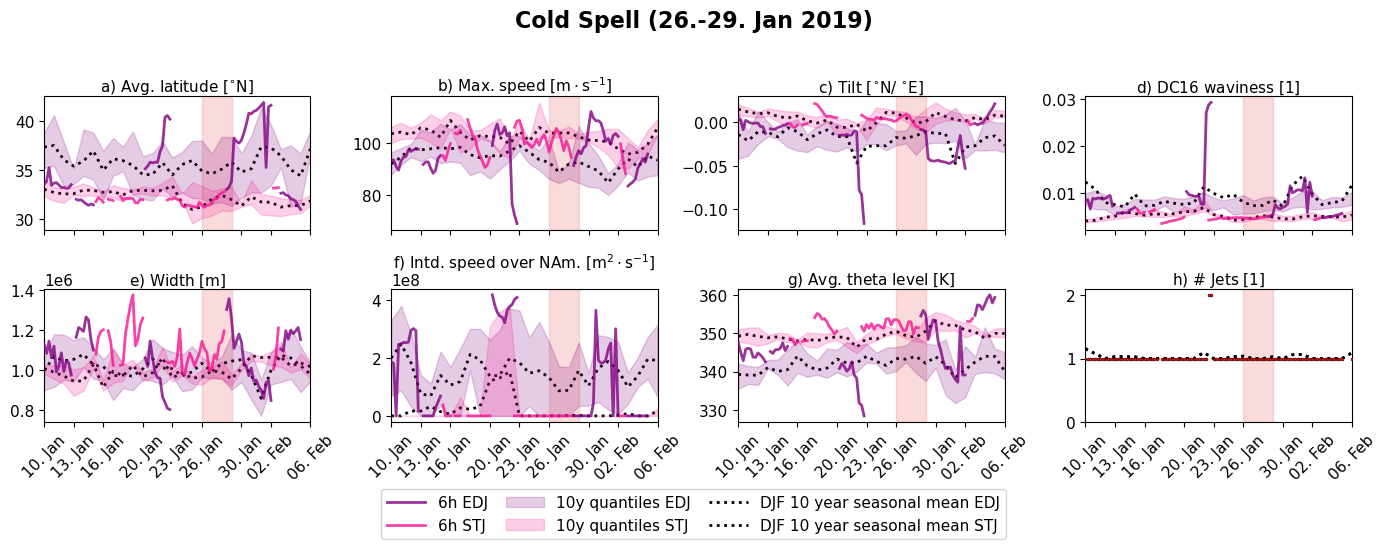

In [64]:
 _ = plot_case_study_NEW(props_as_df, data_vars_medium_DJF, nrows=2, ncols=4 ,start_date = "10012019", end_date = "06022019", suffix=f"ColdSpell2019_med",  numbering=True, save=True, n_xticks = 9, season = 'DJF', start_date_EE =  "26012019", end_date_EE = "29012019", case_name= "Cold Spell", use_6h_data=True)

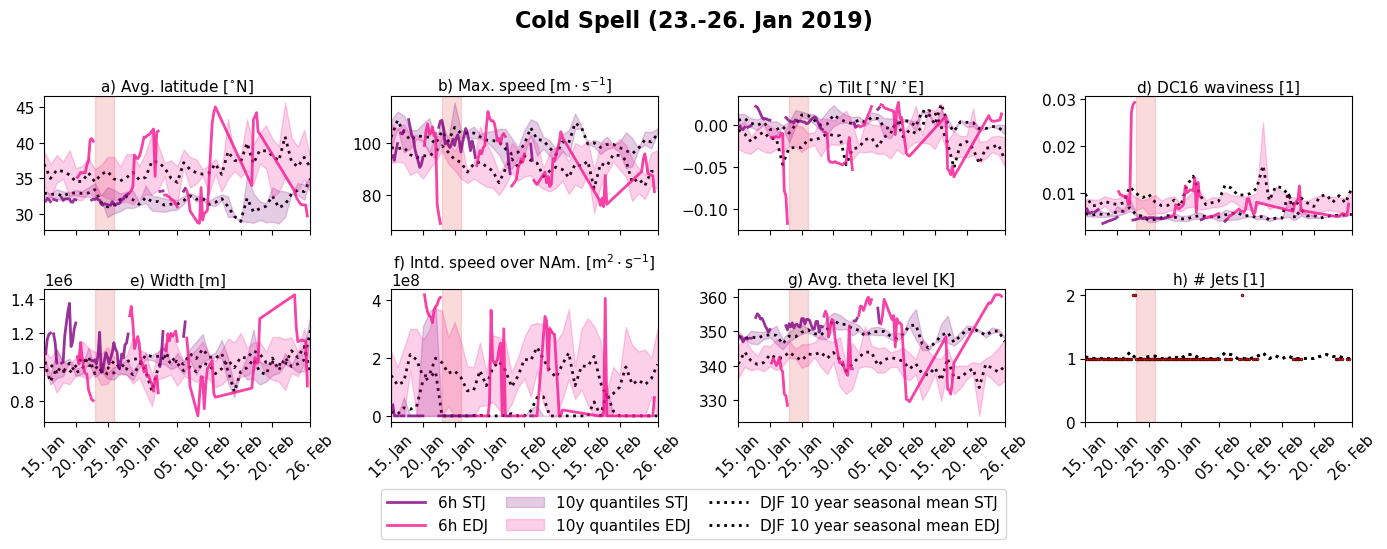

In [67]:
 _ = plot_case_study_NEW(props_as_df, data_vars_medium_DJF,nrows=2, ncols=4 ,start_date = "15012019", end_date = "26022019",suffix=f"ColdSpell2019_med",  numbering=True, save=True, n_xticks = 9, season = 'DJF', start_date_EE =  "23012019" , end_date_EE =  "26012019", case_name= "Cold Spell", use_6h_data=True)

## Winter 13/14

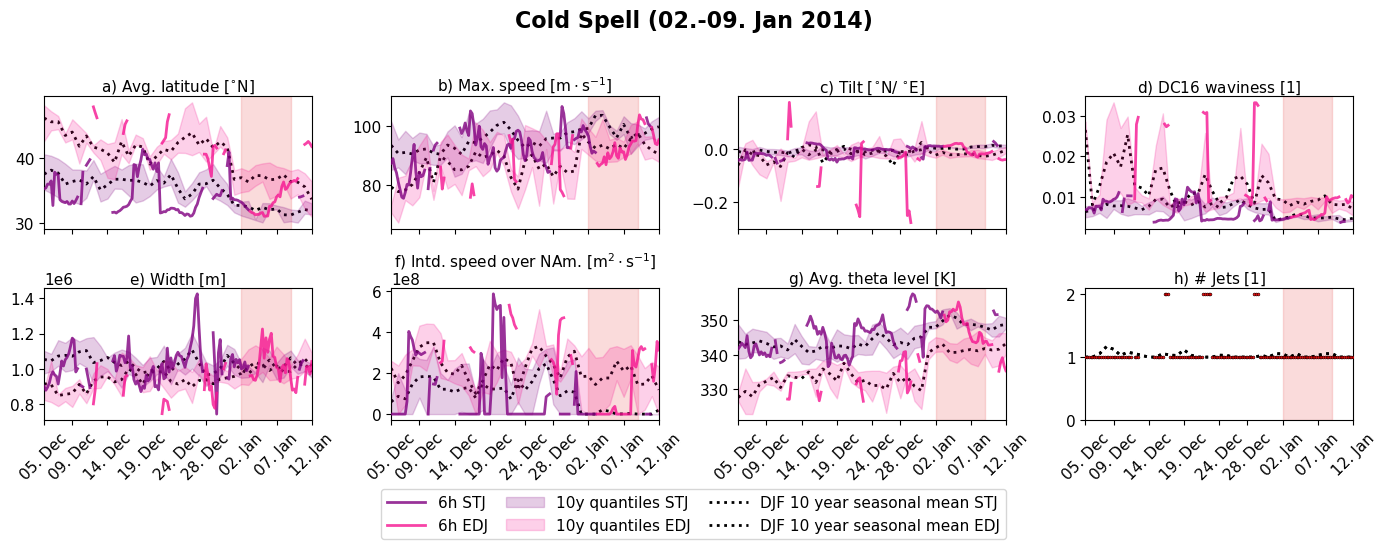

In [68]:
 _ = plot_case_study_NEW(props_as_df_test, data_vars_medium_DJF, nrows=2, ncols=4 , season ='DJF' , start_date = "05122013", end_date = "12012014",suffix=f"ColdSpell1314_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "02012014" , end_date_EE =  "09012014", case_name= "Cold Spell", use_6h_data=True)

## Coldspell 1998

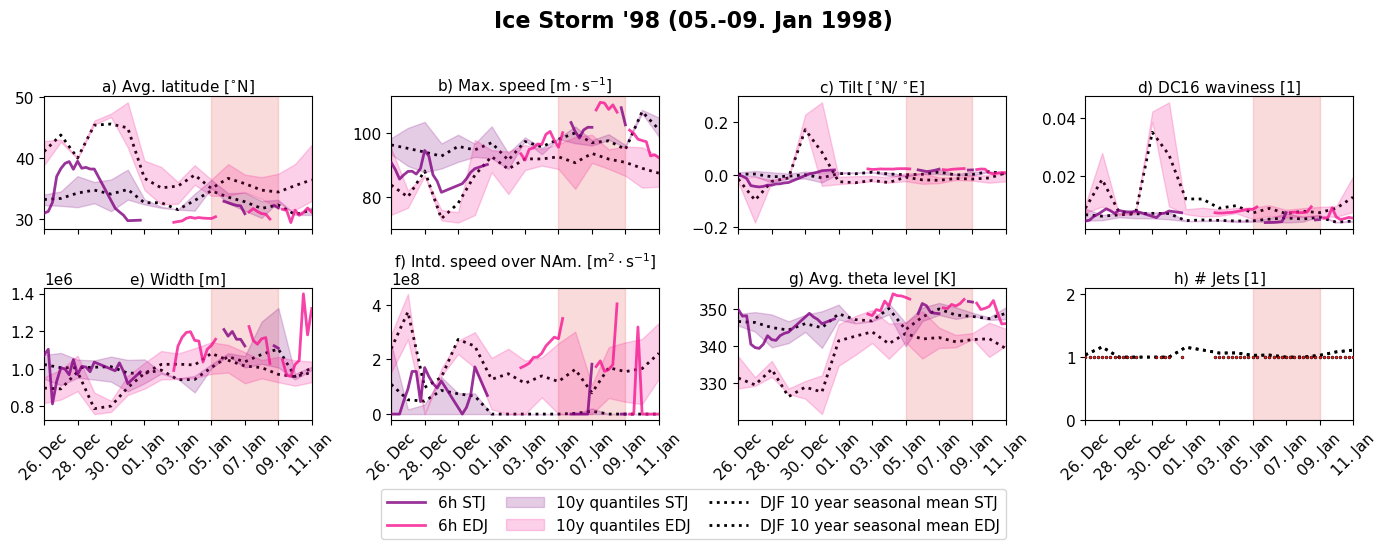

In [69]:
 _ = plot_case_study_NEW(props_as_df, data_vars_medium_DJF, nrows=2, ncols=4 , season ='DJF' , start_date = "26121997", end_date = "11011998",suffix=f"ColdSpell1998_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "05011998" , end_date_EE =  "09011998", case_name= "Ice Storm '98", use_6h_data=True)

### Cold spell Feb 2021

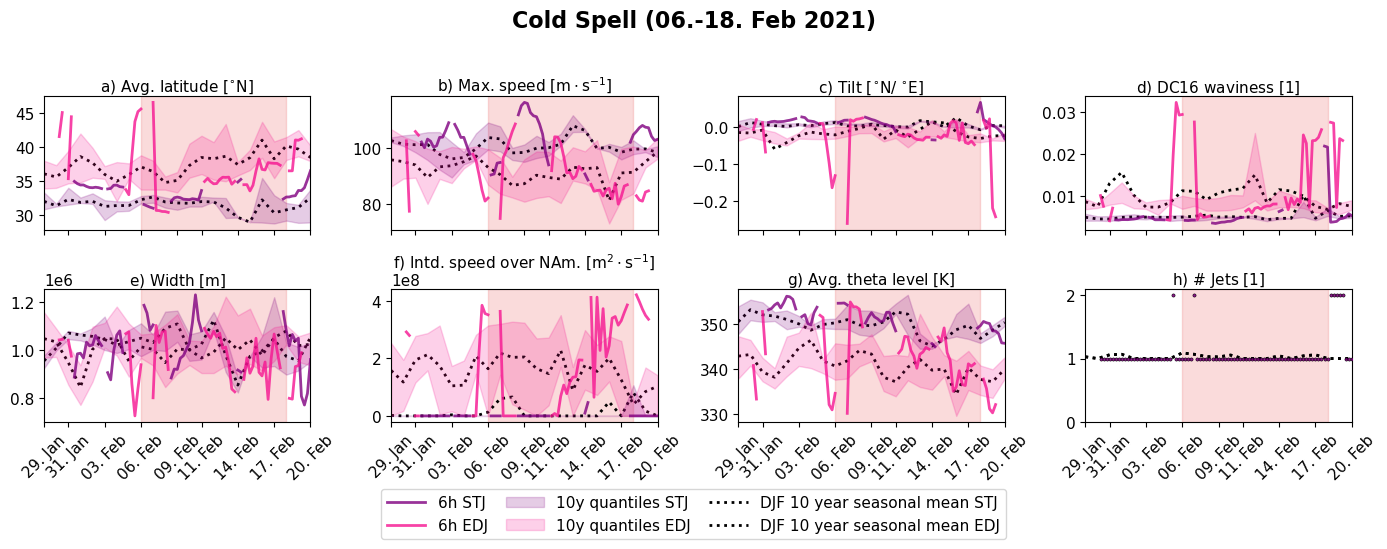

In [70]:
 _ = plot_case_study_NEW(props_as_df, data_vars_medium_DJF, nrows=2, ncols=4 , season ='DJF' , start_date = "29012021", end_date = "20022021",suffix=f"ColdSpell2021_med",  numbering=True, save=True, n_xticks = 9, start_date_EE =  "06022021" , end_date_EE =  "18022021", case_name= "Cold Spell", use_6h_data=True)

# Seasonal Properties

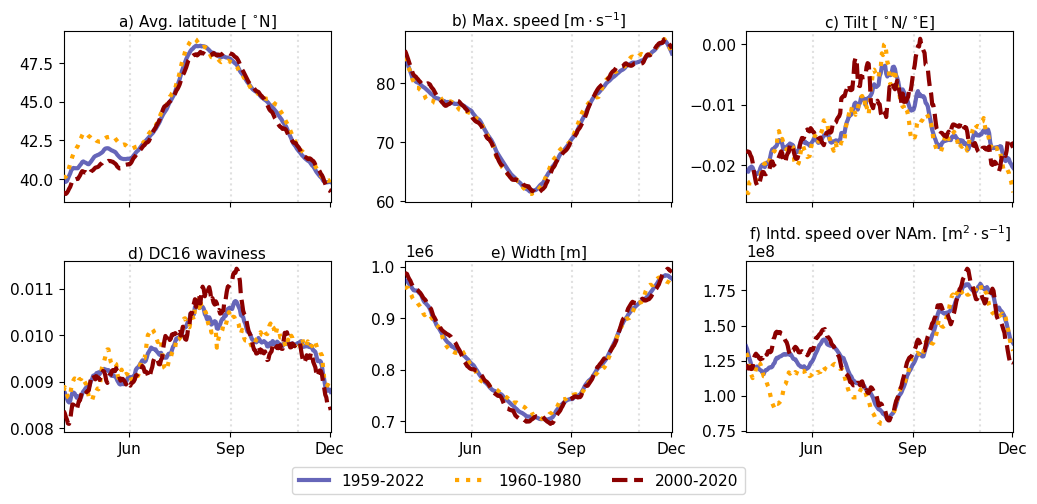

In [ ]:
#better then period1=(1959, 1990), period2=(1991, 2022)
_ = plot_seasonal_summer_periods(
    props_as_df_test, data_vars_small, nrows=2, ncols=3, clear=False, suffix=f"19602000_comparison", numbering=True, save=True, period1=(1960, 1980),
    period2=(2000, 2020)
)

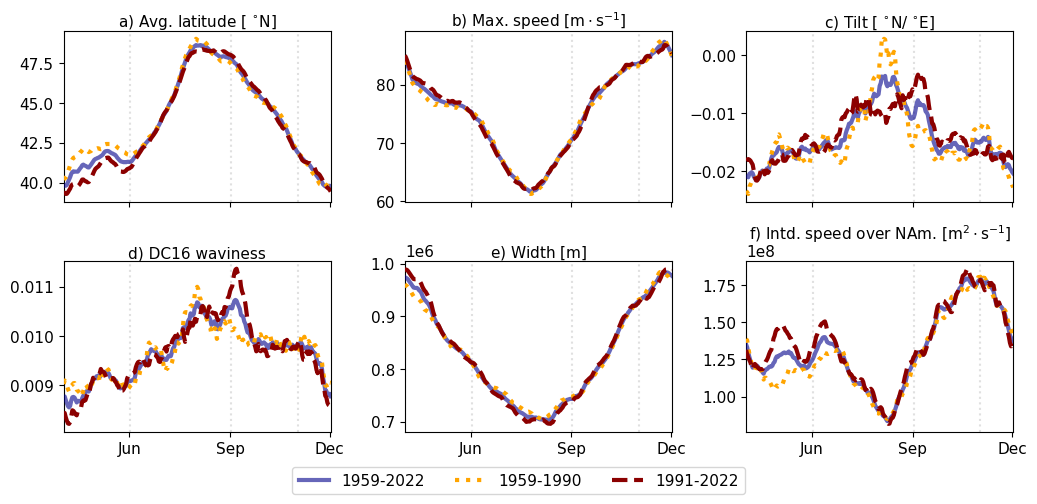

In [28]:
_ = plot_seasonal_summer_periods(
    props_as_df_test, data_vars_small, nrows=2, ncols=3, clear=False, suffix=f"19591991_comparison", numbering=True, save=True, period1=(1959, 1990),
    period2=(1991, 2022)
)

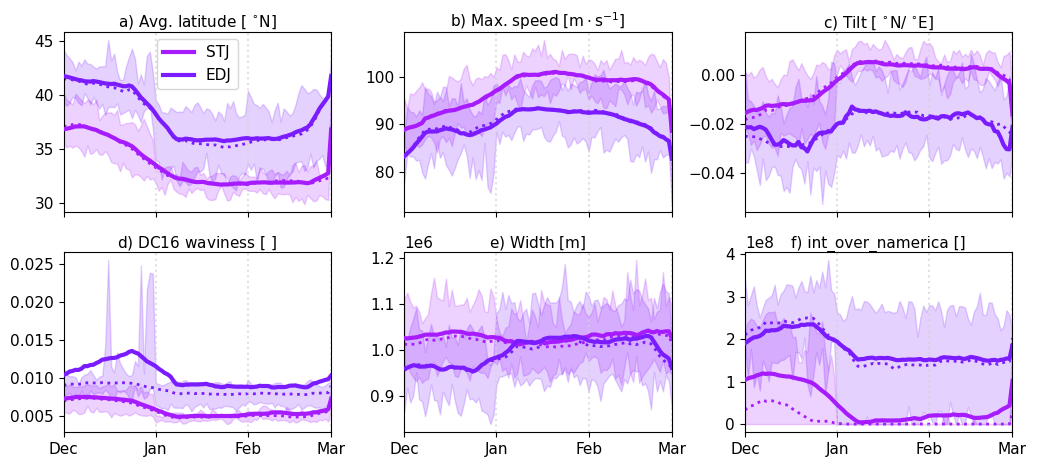

In [ ]:
fig20 = plot_seasonal_winter_jets(
    props_as_df_test, data_vars_small, nrows=2, ncols=3, clear=False, suffix=f"_test2", numbering=True, save=True,
)

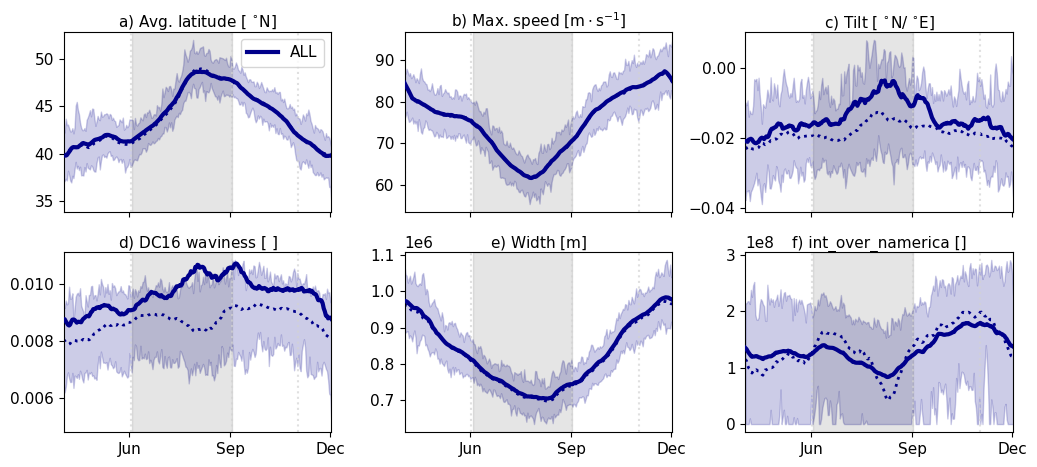

In [ ]:
fig30 = plot_seasonal_summer_all(
    props_as_df_test, data_vars_small, nrows=2, ncols=3, clear=False, suffix=f"_test1", numbering=True, save=True,
)

# Categorization

100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


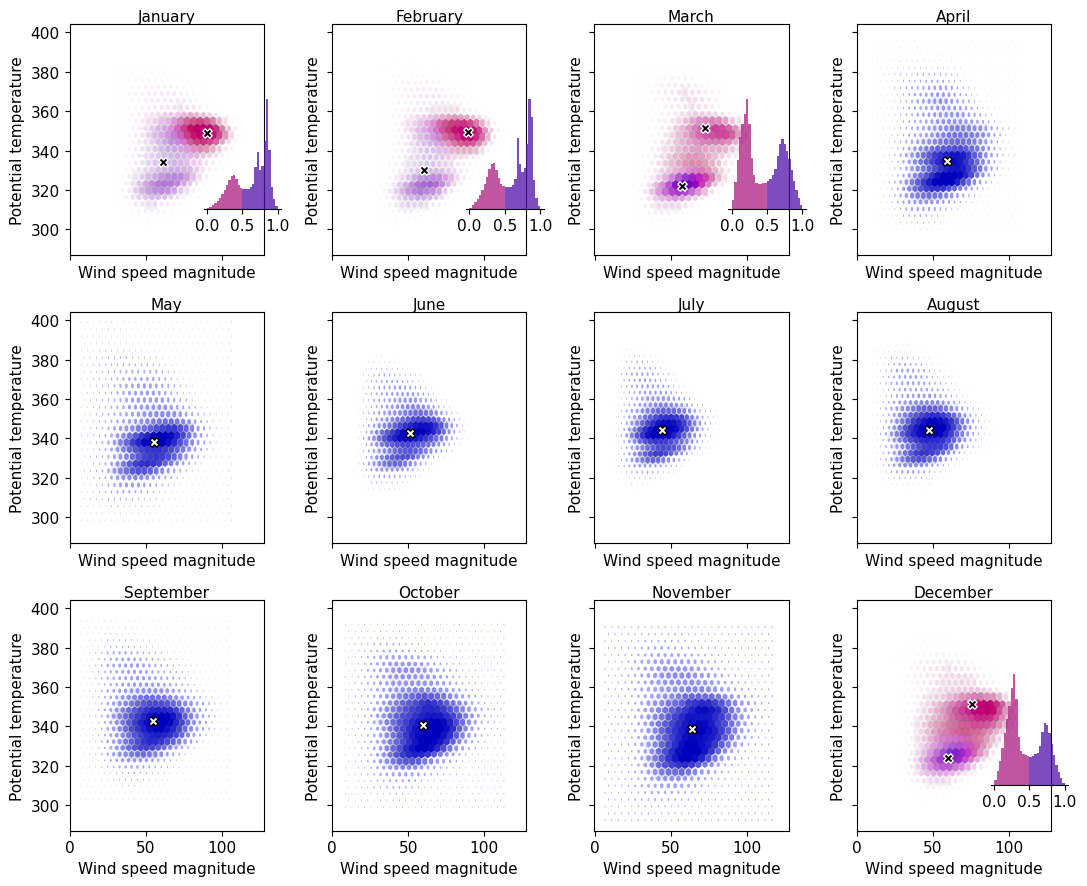

In [ ]:
# Adapted new
# NEWEST - Modified for seasonal categorization
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
from tqdm import trange
from jetutils.jet_finding import extract_features
from jetutils.definitions import MONTH_NAMES
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

xys = []
all_jets = all_jets_one_df
xys = np.array(xys)

fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()

pair = ["s", "theta", "is_polar"]
prettier_names = {
    "s": "Wind speed magnitude", 
    "theta": "Potential temperature",
}

# Define winter months (December-March: 12, 1, 2, 3)
winter_months = [12, 1, 2, 3]

# Original colormap for winter
cmap_winter = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])

# Dark blue colormap for summer
#cmap_summer = LinearSegmentedColormap.from_list("darkblue", ["#08306b", "#2171b5", "#6baed6"])
cmap_summer = LinearSegmentedColormap.from_list("darkblue", ["darkblue", "darkblue"])


bins = np.linspace(0, 1, 31)

for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    
    is_winter = month in winter_months
    
    if is_winter:
        # Winter months: bimodal
        probas = X[pair[2]]
        cmap = cmap_winter
        
        center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
        center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
        
        X1D = X["is_polar"]
        
        im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
        im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
        
        plt.draw()
        
        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        
        colors = cmap(im2.get_array())
        colors = rgb_to_hsv(colors[:, :3])
        min_s, max_s = 0., 1.0
        min_v, max_v = 0.75, 1.
        scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
        f = lambda x: np.sqrt(x)
        colors[:, 1] = min_s + scaling * (max_s - min_s)
        colors[:, 2] = max_v - scaling * (max_v - min_v)
        colors = hsv_to_rgb(colors)
        
        im2.set_array(None)
        im2.set_facecolor(colors)
        im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
        im2.set_edgecolor(colormaps.greys(scaling))
        im2 = ax.add_collection(im2)
        
        stj_plotted_data = X.filter(pl.col("is_polar") < 0.5) 
        edj_plotted_data = X.filter(pl.col("is_polar") > 0.5)
        
        stj_original_data = X.filter(pl.col("is_polar") < 0.3)  # Original STJ threshold
        edj_original_data = X.filter(pl.col("is_polar") > 0.7)  # Original EDJ threshold
        
      
        ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T,
                    facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
        
     
        # Inset histogram for dual cats
        iax = ax.inset_axes([0.69, 0.2, 0.4, 0.5])
        iax.patch.set_alpha(0)
        X1D_clipped = np.clip(X1D, 0, 1)
        iax.hist(X1D_clipped, bins=bins, alpha=0.5, color="black")
        iax.hist(X1D_clipped[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
        iax.hist(X1D_clipped[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
        
    else:
        # Summer months: single cat with dark blue
        cmap = cmap_summer
        
        # Constant value for single cat visualization
        probas = np.ones(len(X)) * 0.5 
        
        # Center
        center_all = X.mean()
        
        im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
        im2 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
        
        plt.draw()
        
        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        
        # Use dark blue coloring
        scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
        colors = cmap_summer(scaling)
        colors = rgb_to_hsv(colors[:, :3])
        
        min_s, max_s = 0.3, 1.0
        min_v, max_v = 0.75, 1.
        f = lambda x: np.sqrt(x)
        colors[:, 1] = min_s + scaling * (max_s - min_s)  
        colors[:, 2] = max_v - scaling * (max_v - min_v)
        colors = hsv_to_rgb(colors)
        
        im2.set_array(None)
        im2.set_facecolor(colors)
        im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
        im2.set_edgecolor(colormaps.greys(scaling))
        im2 = ax.add_collection(im2)
        
        ax.scatter(*center_all[pair[:2]].to_numpy().T,
                  facecolor="white", edgecolor="black", marker="X", linewidths=1, s=45)

    ax.set_xlabel(prettier_names[pair[0]])
    ax.set_ylabel(prettier_names[pair[1]])
    
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis()
        
    ax.set_title(MONTH_NAMES[month - 1])
    
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)

plt.draw()
fig.savefig(f"/home/mabeling/MasterThesis/plots/best_cats_init{init}_{time}_int{thresh}_complete_conditional_nohist_END")

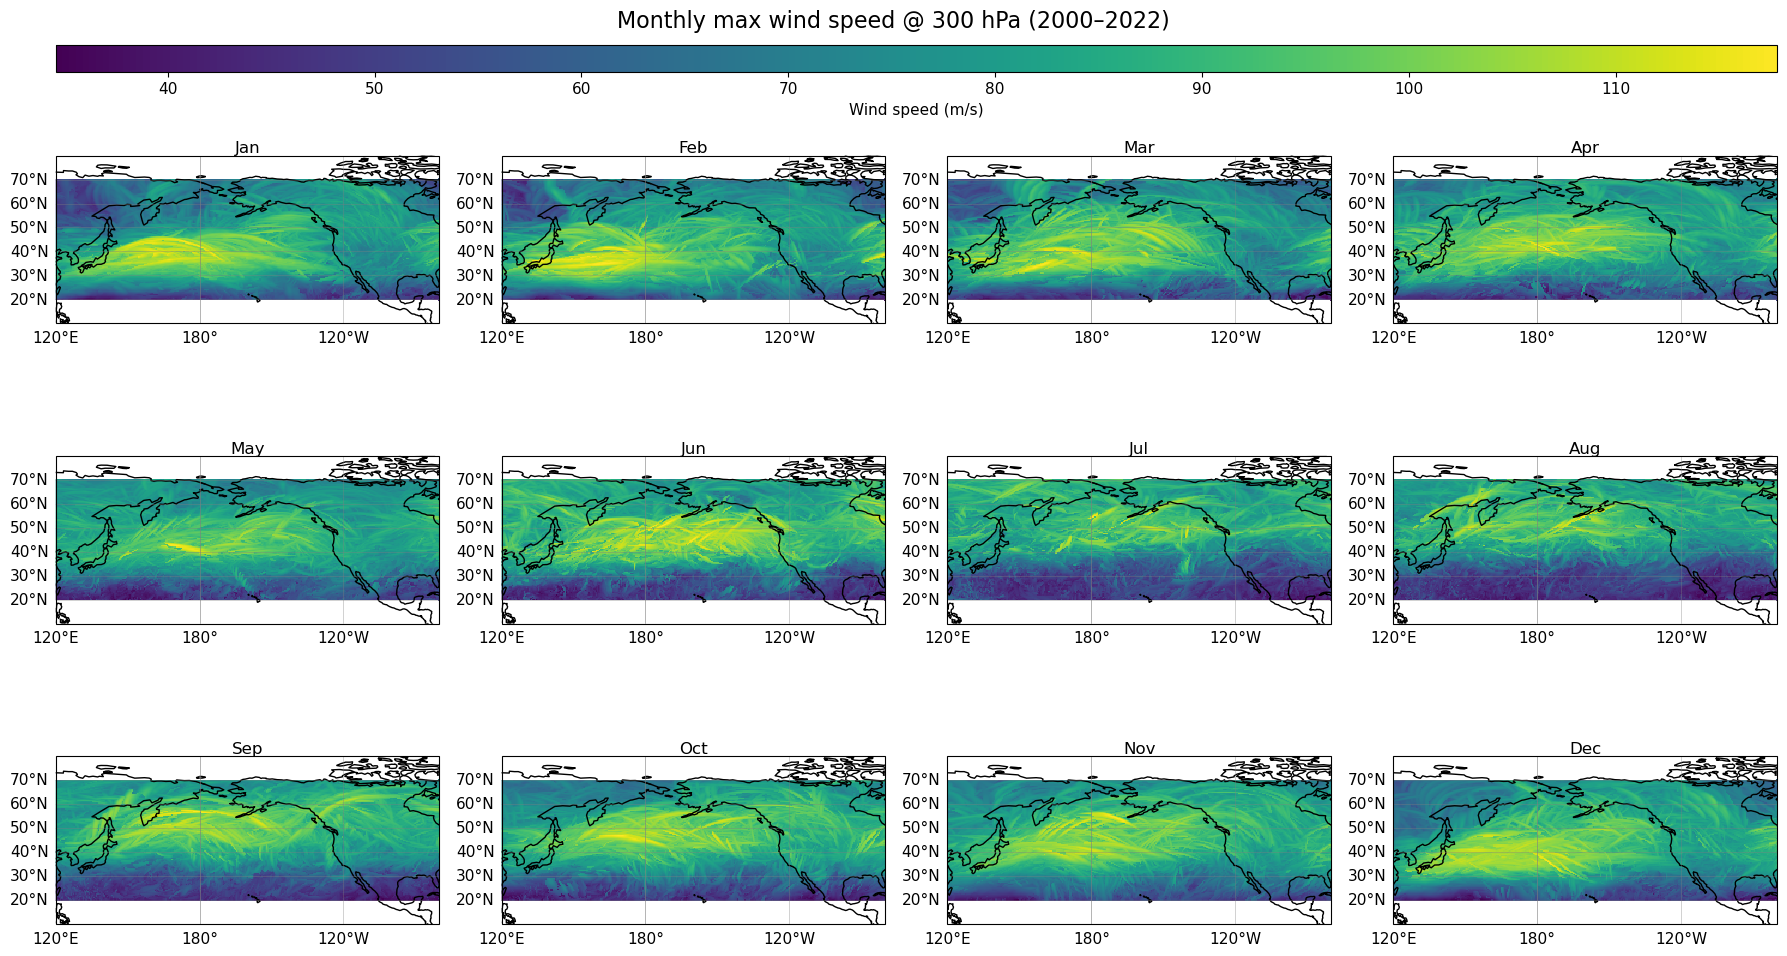

In [78]:
import matplotlib.gridspec as gridspec
import calendar
lev_sel = 300

mask = ds["lev"] == lev_sel
ds_sel = ds.where(mask, drop=True)

# climatological monthly mean across all years
monthly_ws_clim = ds_sel["s"].groupby("time.month").max("time")#.quantile(0.9, dim="time")
# correct longitude wrap
monthly_ws_clim = monthly_ws_clim.assign_coords(
    lon=(((monthly_ws_clim.lon + 180) % 360) - 180)
).sortby("lon")

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(4, 4, height_ratios=[0.1, 1, 1, 1])  # first row cbar

axes = []
for i in range(12):
    row = (i // 4) + 1  # start w/ row 1 (row 0 for cbar)
    col = i % 4
    ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree(central_longitude=180))
    axes.append(ax)

im = None
for i, ax in enumerate(axes):
    ws = monthly_ws_clim.sel(month=i+1)
    im = ws.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        add_colorbar=False,
    )
    ax.coastlines()
    ax.set_extent([120, 280, 10, 80], crs=ccrs.PlateCarree())
    ax.set_title(calendar.month_abbr[i+1], fontsize=12)

    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False 

# colorbar in the top row
cbar_ax = fig.add_subplot(gs[0, :])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Wind speed (m/s)")

plt.suptitle(f"Monthly max wind speed @ {lev_sel} hPa (2000–2022)", fontsize=16)
plt.tight_layout()
plt.savefig(f"/home/mabeling/MasterThesis/plots/snapshots/2000-2022mmaxs{lev_sel}hPa.png", dpi=300, bbox_inches='tight')

plt.show()